In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import inf, sqrt
from scipy.stats import norm, t, binom, poisson, chi2, f, ttest_ind, rankdata
from sklearn.linear_model import LinearRegression

In [2]:
# DEFAULT PARAMETERS
primary_plot_color = "C0" # tab:blue
secondary_plot_color = "C8" # tab:olive
acceptable_color = "C2" # tab:green
critical_color = "C3" # tab:red

FIGURE_PATH = "../LaTeX/figures/"

def format_float(x, num_decimals=4):
    return (f'%.{num_decimals}f' % x).rstrip('0').rstrip('.')

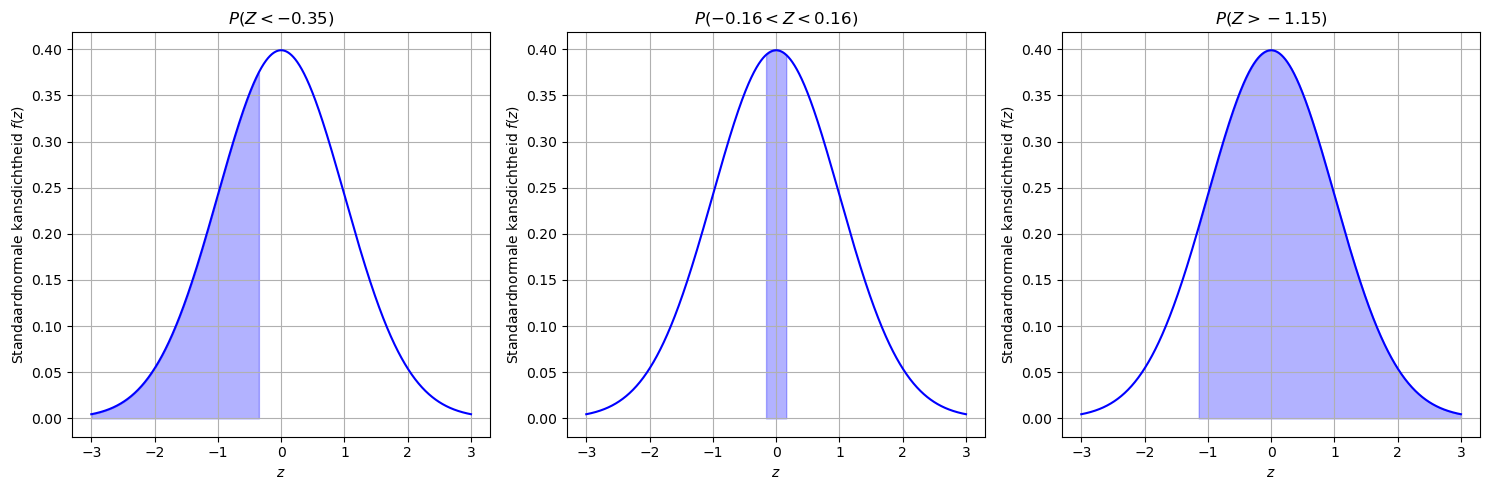

In [3]:
# Definieer de Z-waarden voor de kansen
z_values = [(-np.inf, -0.35), (-0.16, 0.16), (-1.15, np.inf)]
titles = [r"$P(Z < -0.35)$", r"$P(-0.16 < Z < 0.16)$", r"$P(Z > -1.15)$"]

# Genereer de standaardnormale verdeling
x = np.linspace(-3, 3, 1000)
y = norm.pdf(x, 0, 1)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for ax, (z_min, z_max), title in zip(ax, z_values, titles):
    ax.plot(x, y, color="blue")  # Kansdichtheidsfunctie
    
    # Invullen van het gebied onder de curve
    mask = (x >= z_min) & (x <= z_max)
    ax.fill_between(x[mask], y[mask], color="blue", alpha=0.3)

    ax.set_title(title)
    ax.set_xlabel("$z$")
    ax.set_ylabel("Standaardnormale kansdichtheid $f(z)$")
    ax.grid(True)

plt.tight_layout()
plt.show()

# Voorspellingsintervallen

In [4]:
def prediction_interval_normal(mu=0, sigma=1, alpha=0.05, filename="test_prediction_interval.png"):
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
    y = norm.pdf(x, mu, sigma)
    confidence_level = 1 - alpha
    confidence_percentage = int(100 * confidence_level)

    left = norm.ppf(alpha / 2, mu, sigma)
    right = norm.ppf(1 - alpha / 2, mu, sigma)
    
    # Plot characterization
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color=primary_plot_color)
    plt.fill_between(x, y, where=((x >= left)&(x<=right)), color=primary_plot_color, alpha=0.2)
    plt.plot([left, left], [0, norm.pdf(left, mu, sigma)], color=primary_plot_color, linestyle='--')
    plt.plot([right, right], [0, norm.pdf(right, mu, sigma)], color=primary_plot_color, linestyle='--')

    plt.suptitle(f'${confidence_percentage}\\%$-voorspellingsinterval voor $X \\sim N(\\mu={mu}, \\sigma={sigma})$')
    plt.title(f"Voorspellingsinterval: $[{left:.4f}; {right:.4f}]$")

    plt.xlabel('$x$')
    plt.ylabel('Normale kansdichtheid $f(x)$')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.tight_layout()

    # Save figure
    plt.savefig(filename)

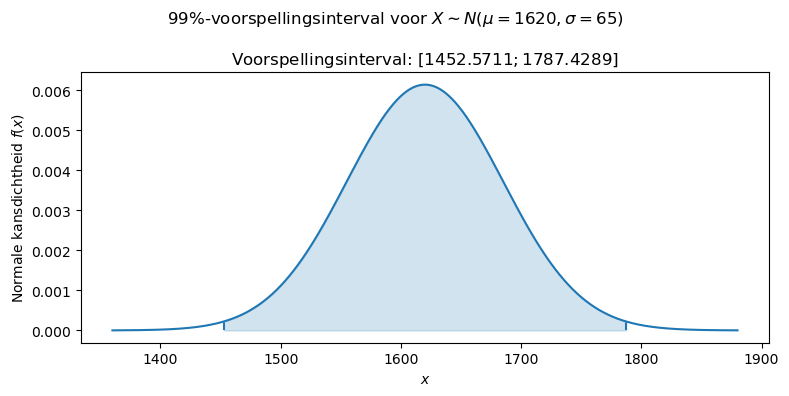

In [5]:
prediction_interval_normal(mu=1620, sigma=65, alpha=0.01, filename=FIGURE_PATH + "opg13.9c.png")

# Hypothesetoetsen

## Toetsen voor het gemiddelde $\mu$

In [6]:
def determine_critical_values(test_type, mu_0, sample_std, alpha, xmin, xmax):
    if test_type == "tweezijdig":
        # Kritieke waarde onder H0 (voor tweezijdige toets)
        z_alpha = norm.ppf(1 - alpha / 2)
        critical_value_left = mu_0 - z_alpha * sample_std
        critical_value_right = mu_0 + z_alpha * sample_std
    elif test_type == "linkszijdig":
        # Kritieke waarde onder H0 (voor linkszijdige toets)
        z_alpha = norm.ppf(1 - alpha)
        critical_value_left = mu_0 - z_alpha * sample_std
        critical_value_right = xmax
    else:
        # Kritieke waarde onder H0 (voor rechtszijdige toets)
        z_alpha = norm.ppf(1 - alpha)
        critical_value_left = xmin
        critical_value_right = mu_0 + z_alpha * sample_std
    return critical_value_left, critical_value_right
    
def plot_hypothesis_testing(test_type="tweezijdig", mu_0=0, mu_1=None, sigma=1, alpha=0.05, sample_size=30, test_stat=None, filename="test.txt"):
    fig, ax = plt.subplots(figsize=(12,7.5))
    sample_std = sigma / np.sqrt(sample_size)

    if mu_1:
        maxmu = max(mu_0, mu_1)
        minmu = min(mu_0, mu_1)
    else:
        maxmu, minmu = mu_0, mu_0
    x = np.linspace(minmu - 4 * sample_std, maxmu + 4 * sample_std, 1_000)
    xmin, xmax = x[0], x[-1]
    
    opacity = 0.2

    # H_0 specifics
    pdf_H0 = norm.pdf(x, mu_0, sample_std)

    # H1 specifics
    if mu_1:
        pdf_H1 = norm.pdf(x, mu_1, sample_std)

    # Draw horizontal lines indicating the regions
    xmin, xmax = x[0], x[-1]
    ymax = max(pdf_H0)
    ytext = -0.2 * ymax  # Position for the horizontal line 
    ymu = 1/4 * ytext
    ylines = 1/2 * ytext

    ax.set_ylim(bottom=1.5*ytext, top=1.1*ymax)
    ax.set_xlabel('Toetsingsgrootheid $\\overline{x}$')
    ax.set_ylabel('Kansdichtheidsfunctie $f(\\overline{x})$')
    
    # Plot instellen
    ax.plot(x, pdf_H0, color=primary_plot_color, alpha=0.7, label="Kansverdeling van $\\overline{X}$ onder $H_0$")
    ax.plot([mu_0, mu_0], [0, norm.pdf(mu_0, mu_0, sample_std)], color=primary_plot_color, linestyle='--')
    ax.text(mu_0, ymu, "$\\mu_0$", color=primary_plot_color, ha="center", va="center")

    if mu_1:
        ax.plot(x, pdf_H1, color=secondary_plot_color, alpha=0.7, label="Kansverdeling van $\\overline{X}$ onder $H_1$")
        ax.plot([mu_1, mu_1], [0, norm.pdf(mu_1, mu_1, sample_std)], color=secondary_plot_color, linestyle='--')
        ax.text(mu_1, ymu, "$\\mu_1$", color=secondary_plot_color, ha="center", va="center")

    # Determine the critical values
    critical_value_left, critical_value_right = determine_critical_values(test_type, mu_0, sample_std, alpha, xmin, xmax)

    # Shade the critical region
    ax.plot([critical_value_left, critical_value_left], [0, norm.pdf(critical_value_left, mu_0, sample_std)], color=critical_color, linestyle='-')#, label='Kritieke grens links')
    ax.fill_between(x, 0, pdf_H0, where=(x < critical_value_left), color=critical_color, alpha=opacity, label=f'Type-I fout ($\\alpha$): {alpha:.3f}')
    ax.plot([critical_value_right, critical_value_right], [0, norm.pdf(critical_value_right, mu_0, sample_std)], color=critical_color, linestyle='-')#, label='Kritieke grens rechts')
    ax.fill_between(x, 0, pdf_H0, where=(x > critical_value_right), color=critical_color, alpha=opacity)

    # Bereken de type-II fout en arceer de bijbehorende oppervlaktes (wat is de kans op een waarde in het acceptatiegebied?)
    if mu_1:
        beta = norm.cdf(critical_value_right, loc=mu_1, scale=sample_std) - norm.cdf(critical_value_left, loc=mu_1, scale=sample_std)
        ax.fill_between(x, 0, pdf_H1, where=((x < critical_value_right) & (x > critical_value_left)), color=secondary_plot_color, alpha=opacity, label=f'Type II fout ($\\beta$): {beta:.3f}')

    if test_type == "tweezijdig":
        label_critical_region = f"Kritiek gebied: $(-\\infty; {critical_value_left:.2f}]$ en $[{critical_value_right:.2f}; \\infty)$"        
        plt.suptitle(f'Tweezijdige hypothesetoets: $H_0$: $\\mu={mu_0}$ vs. $H_1$: $\\mu \\neq {mu_0}$', fontsize=20)
        
    elif test_type == "rechtszijdig":
        label_critical_region = f"Kritiek gebied: $[{critical_value_right:.2f}; \\infty)$"               
        plt.suptitle(f'Rechtszijdige hypothesetoets: $H_0$: $\\mu\\leq{mu_0}$ vs. $H_1$: $\\mu > {mu_0}$', fontsize=20)
        
    else: # linkszijdig
        label_critical_region = f"Kritiek gebied: $(-\\infty; {critical_value_left:.2f}]$"        
        plt.suptitle(f'Linkszijdige hypothesetoets: $H_0$: $\\mu\\geq{mu_0}$ vs. $H_1$: $\\mu < {mu_0}$', fontsize=20)

    # Teken het acceptatiegebied
    ax.hlines(ylines, critical_value_left, critical_value_right, color=acceptable_color, linewidth=5)
    ax.text((critical_value_left + critical_value_right) / 2, ytext, 'Accepteer $H_0$', color=acceptable_color, fontsize=11, ha='center')
    
    # Teken het kritieke gebied
    ax.hlines(ylines, xmin, critical_value_left, color=critical_color, linewidth=5, label=label_critical_region)
    ax.hlines(ylines, critical_value_right, xmax, color=critical_color, linewidth=5)
    if critical_value_left != xmin:
        ax.text((critical_value_left + xmin) / 2, ytext, 'Verwerp $H_0$', color=critical_color, fontsize=11, ha='center')
    if critical_value_right != xmax:
        ax.text((critical_value_right + xmax) / 2, ytext, 'Verwerp $H_0$', color=critical_color, fontsize=11, ha='center')
    
    ax.set_title(f"Kansdichtheidsfunctie van het steekproefgemiddelde $\\overline{{X}}\\sim N(\\mu={mu_0}; \\sigma = \\frac{{{sigma}}}{{\\sqrt{{{sample_size}}}}})$")
    
    if test_stat:
        ax.plot([test_stat, test_stat], [0, norm.pdf(test_stat, mu_0, sample_std)], color=primary_plot_color, linestyle="--")
        ax.text(test_stat, ytext, '$\\overline{x}$', color='black', fontsize=11, ha='center')
        
    ax.legend()
    plt.savefig(filename)

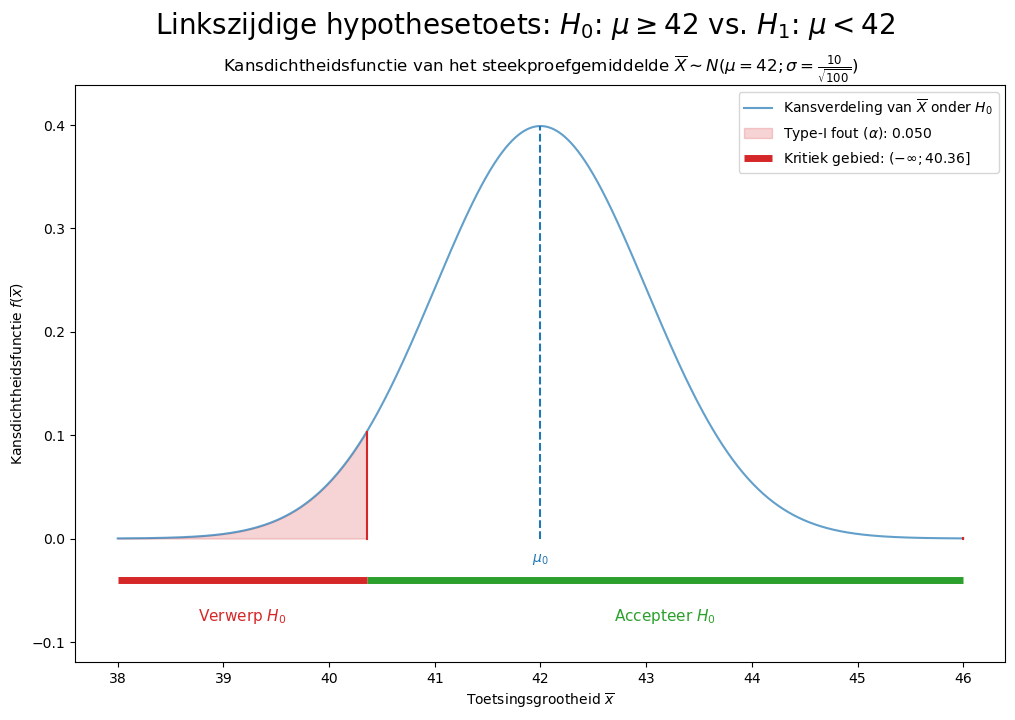

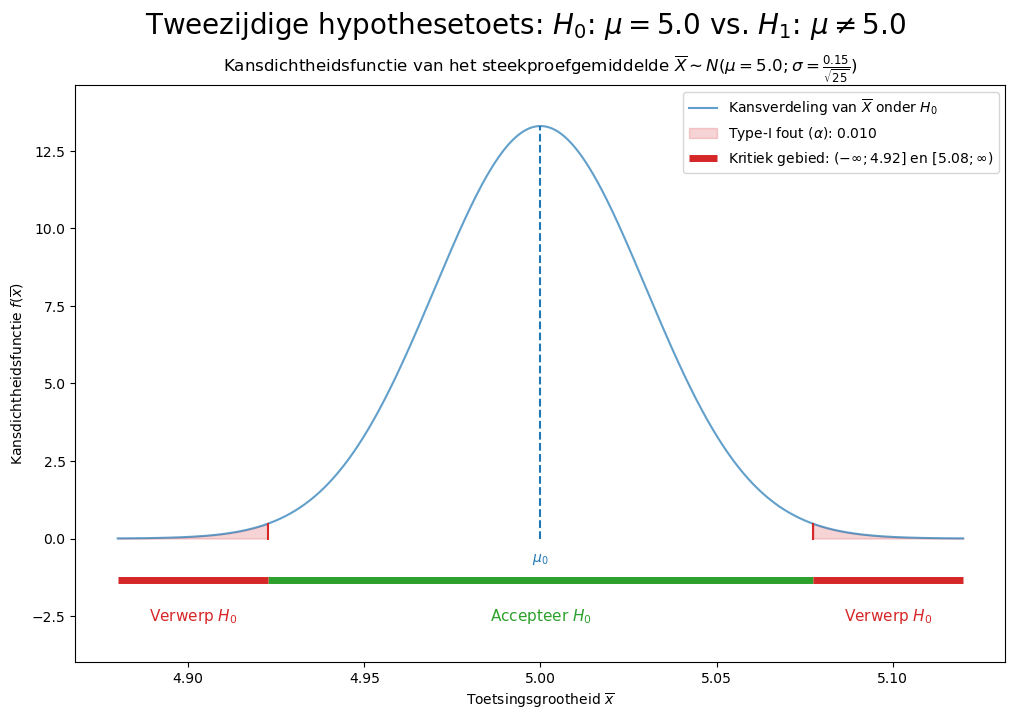

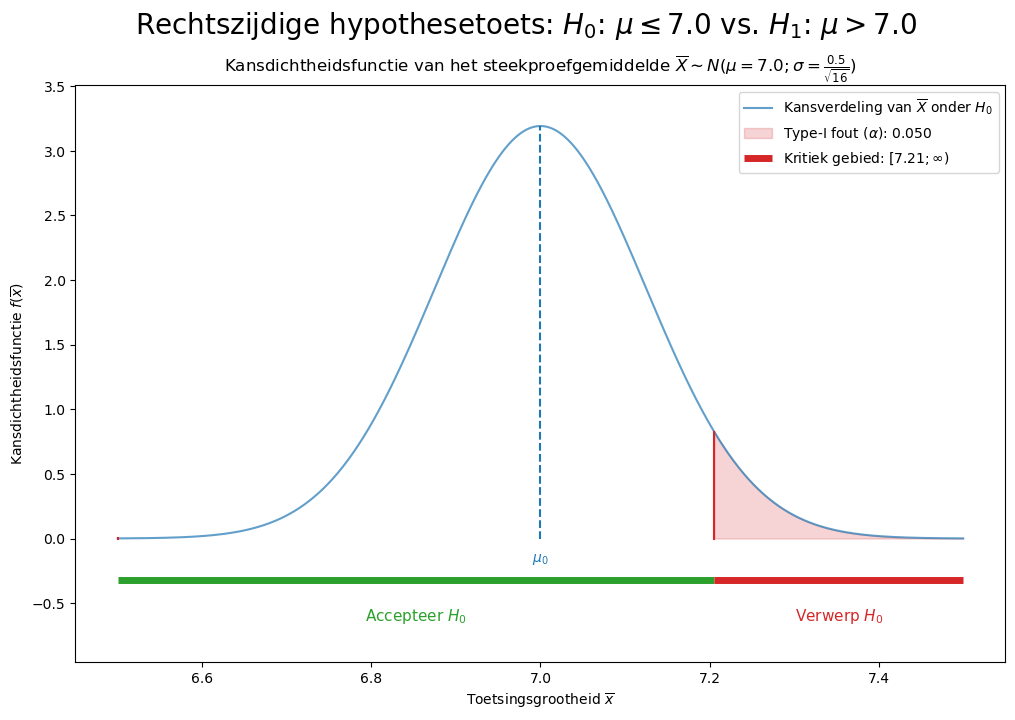

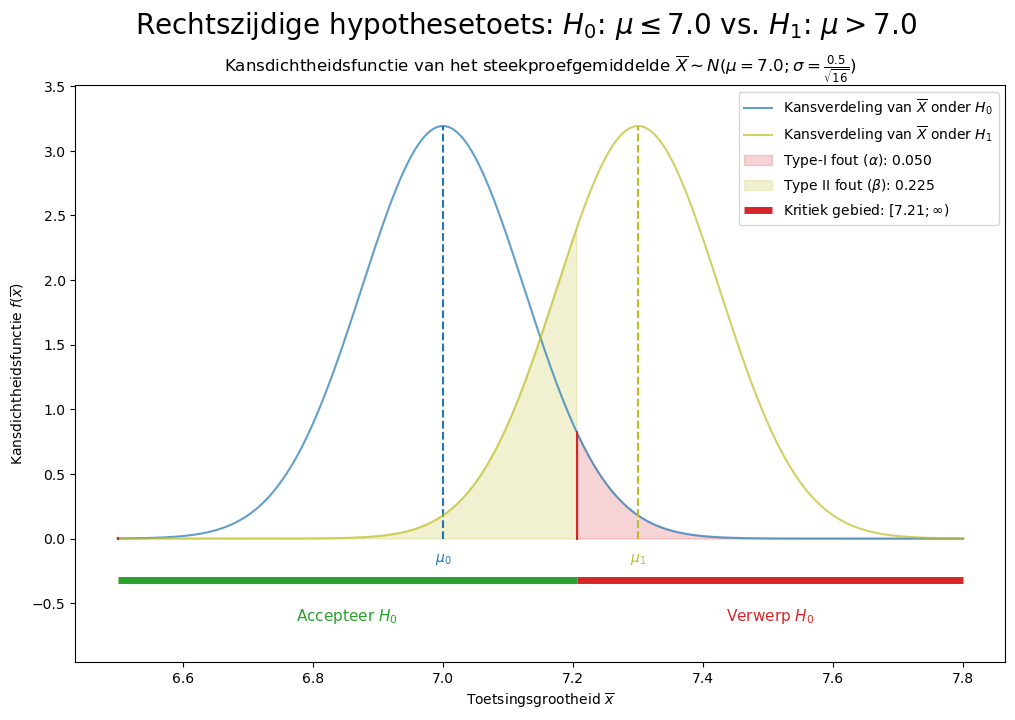

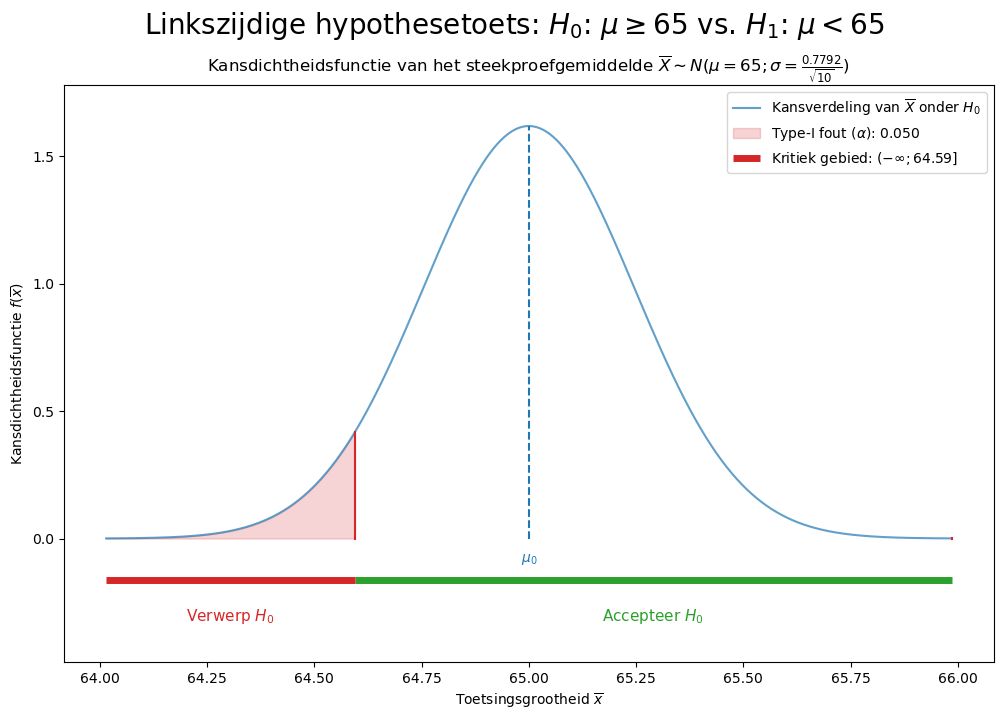

In [7]:
plot_hypothesis_testing(test_type="linkszijdig", mu_0=42, mu_1=None, sigma=10, alpha=0.05, sample_size=100, test_stat=None, filename=FIGURE_PATH + "opg_9.5.png")
plot_hypothesis_testing(test_type="tweezijdig", mu_0=5.0, mu_1=None, sigma=0.15, alpha=0.01, sample_size=25, test_stat=None, filename=FIGURE_PATH + "opg_9.7b.png")
plot_hypothesis_testing(test_type="rechtszijdig", mu_0=7.0, mu_1=None, sigma=0.5, alpha=0.05, sample_size=16, test_stat=None, filename=FIGURE_PATH + "opg_9.23a.png")
plot_hypothesis_testing(test_type="rechtszijdig", mu_0=7.0, mu_1=7.30, sigma=0.5, alpha=0.05, sample_size=16, test_stat=None, filename=FIGURE_PATH + "opg_9.23b.png")

plot_hypothesis_testing(test_type="linkszijdig", mu_0=65, sigma=0.7792, alpha=0.05, sample_size=10, test_stat=None, filename=FIGURE_PATH + "exam20250704_q4.png")

# Chikwadraattoetsen

In [8]:
def chi2_choose_domain(df):
    if df <= 5:
        xmin = 0.001
    else:
        xmin = 0

    xmax = chi2.ppf(0.999, df=df)
    return xmin, xmax

def chi2_calculate_yaxis_ub(y, df):
    # Set the top of y-axis to enhance visibility for lower degrees of freedom
    if df <= 2:
        top = 0.5
    else:
        top = max(y) * 1.1
    return top
    
def chi2_p_value(test_statistic, alpha, df, filename):
    xmin, xmax = chi2_choose_domain(df=df)
    x = np.linspace(xmin, xmax, 1000)
    y = chi2.pdf(x, df=df)
    maxy = chi2_calculate_yaxis_ub(y, df=df)
    
    # Kansberekening
    critical_value = chi2.ppf(q=1-alpha, df=df)
    p_value = 1 - chi2.cdf(test_statistic, df=df)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x, y)
    if test_statistic:
        plt.fill_between(x, y, where=(x >= test_statistic), color=primary_plot_color, alpha=0.5, label=f"$p={p_value:.4f}$")
        plt.plot([test_statistic, test_statistic], [0, chi2.pdf(test_statistic, df=df)], color=primary_plot_color, linestyle='--')
        plt.text(test_statistic, -0.08 * maxy, "$\\chi^2$", color=primary_plot_color, ha="center")

    plt.fill_between(x, y, where=(x >= critical_value), color=critical_color, alpha=0.5, label=f"$\\alpha={alpha}$")
    plt.plot([critical_value, critical_value], [0, chi2.pdf(critical_value, df=df)], color=critical_color, linestyle='--')
    plt.text(critical_value, -0.08 * maxy, "$g$", color=critical_color, ha="center")
    
    plt.title(f'Chikwadraatverdeling met df$={df}$ vrijheidsgraden')
    plt.xlabel('$x$')
    plt.ylabel('Kansdichtheid $f(x)$')
    plt.ylim(bottom=-0.12 * maxy, top=maxy)
    plt.tight_layout()
    plt.legend()
    plt.savefig(filename, format='png')


def chi2_critical_value(test_statistic, alpha, df, filename):
    xmin, xmax = chi2_choose_domain(df=df)
    x = np.linspace(xmin, xmax, 1000)
    y = chi2.pdf(x, df=df)
    maxy = chi2_calculate_yaxis_ub(y, df=df)
    
    # Kansberekening
    critical_value = chi2.ppf(q=1-alpha, df=df)
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x, y)

    if test_statistic:
        plt.plot([test_statistic, test_statistic], [0, chi2.pdf(test_statistic, df=df)], color=primary_plot_color, linestyle='--', label=f"$\\chi^2={test_statistic:.4f}$")
        plt.text(test_statistic, -0.08 * maxy, "$\\chi^2$", color=primary_plot_color, ha="center")

    plt.fill_between(x, y, where=(x >= critical_value), color=critical_color, alpha=0.3, label=f"Kritiek gebied: $[g,\\infty) = [{critical_value:.4f}: \\infty)$")
    plt.plot([critical_value, critical_value], [0, chi2.pdf(critical_value, df=df)], color=critical_color, linestyle='--')
    plt.text(critical_value, -0.08 * maxy, "$g$", color=critical_color, ha="center")
    
    plt.title(f'Chikwadraatverdeling met df$={df}$ vrijheidsgraden')
    plt.xlabel('$x$')
    plt.ylabel('Kansdichtheid $f(x)$')
    plt.ylim(bottom=-0.12 * maxy, top=maxy)
    plt.legend()
    plt.tight_layout()

    plt.savefig(filename, format='png')


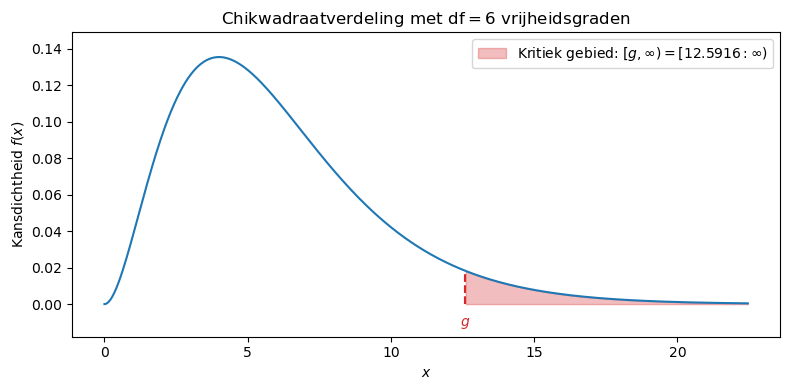

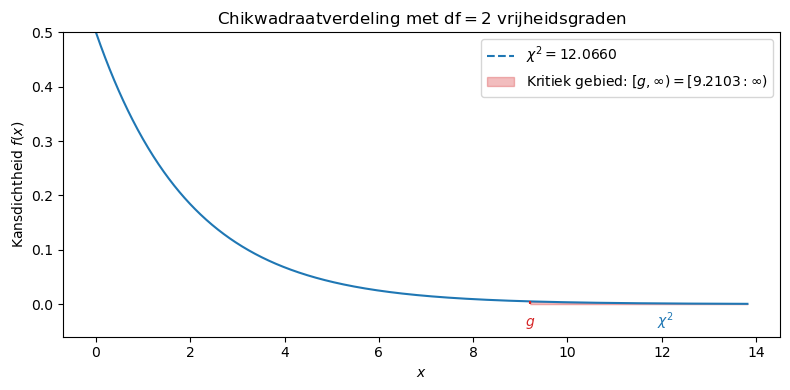

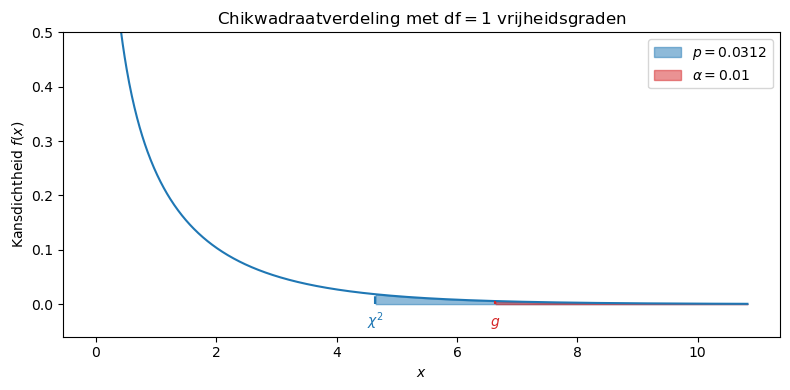

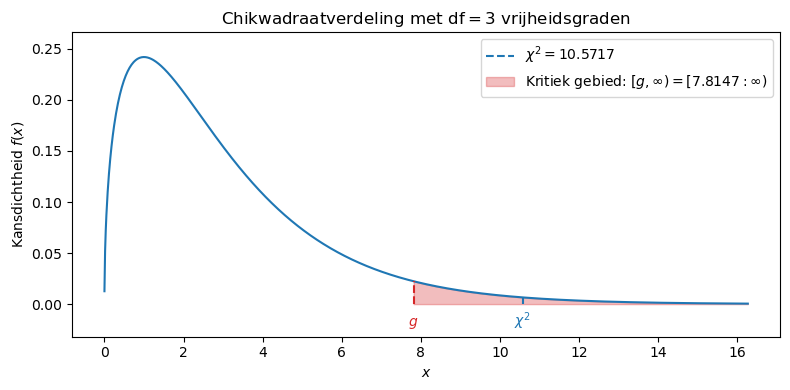

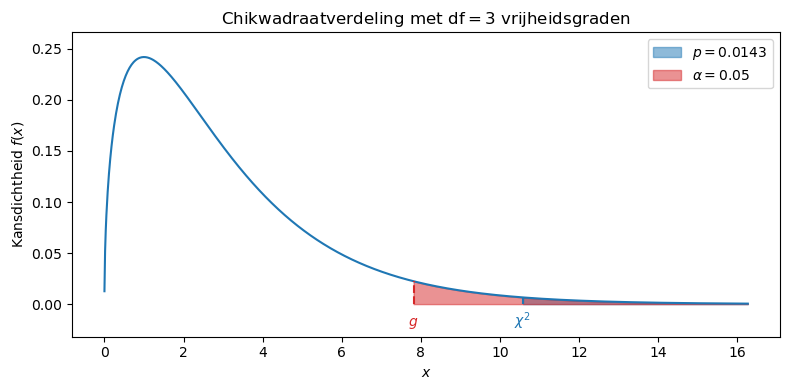

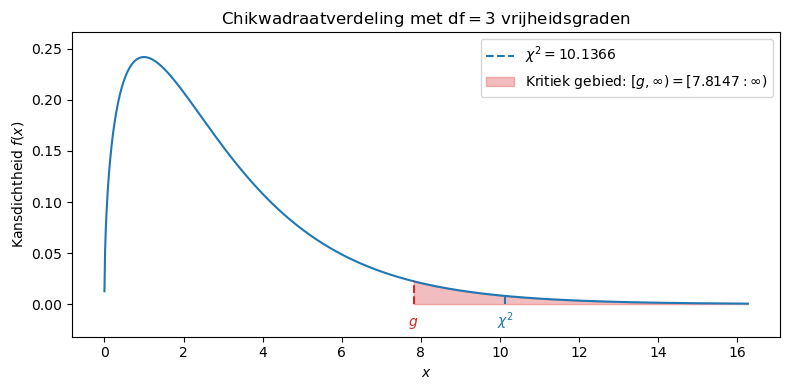

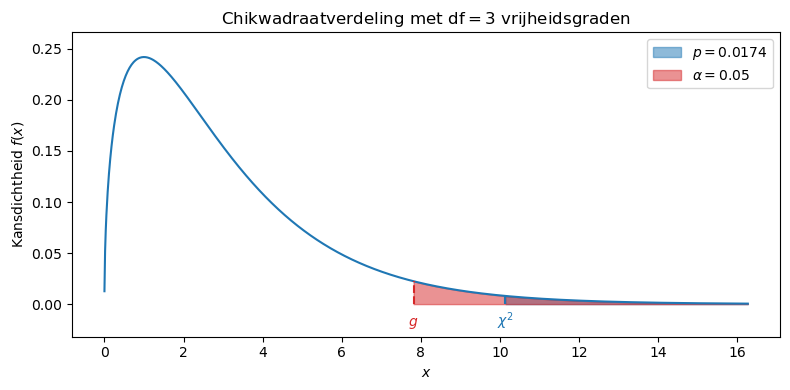

In [9]:
chi2_critical_value(test_statistic=None, alpha=0.05, df=6, filename=FIGURE_PATH + "opg_10.m2.png")

chi2_critical_value(test_statistic=12.0660, alpha=0.01, df=2, filename=FIGURE_PATH + "opg_10.1.png")

chi2_p_value(test_statistic=4.6402, alpha=0.01, df=1, filename=FIGURE_PATH + "opg_10.5.png")

chi2_critical_value(test_statistic=10.5717, alpha=0.05, df=3, filename=FIGURE_PATH + "opg_10.12_kritiek.png")
chi2_p_value(test_statistic=10.5717, alpha=0.05, df=3, filename=FIGURE_PATH + "opg_10.12_p_waarde.png")

chi2_critical_value(test_statistic=10.1366, alpha=0.05, df=3, filename=FIGURE_PATH + "opg_10.13_kritiek.png")
chi2_p_value(test_statistic=10.1366, alpha=0.05, df=3, filename=FIGURE_PATH + "opg_10.13_p_waarde.png")

# Verschiltoetsen

In [10]:
def f_choose_domain(test_statistic, critical_value_right, dfn, dfd):
    if max(dfn, dfd) <= 10:
        xmin, xmax = 0, max(10, test_statistic + 1)
    else:
        xmin, xmax = 0, max(6, test_statistic + 1)
    return xmin, xmax

def f_calculate_yaxis_ub(y, dfn, dfd):
    if dfn <= 2 or dfd <= 2:
        top = 0.5
    else:
        top = max(y) * 1.1
    return top

def plot_F_toets(f_statistic, alpha, dfn, dfd, filename):
    critical_value_left = f.ppf(q=alpha/2, dfn=dfn, dfd=dfd)
    critical_value_right = f.ppf(q=1-alpha/2, dfn=dfn, dfd=dfd)
    
    xmin, xmax = f_choose_domain(f_statistic, critical_value_right, dfn, dfd)
    x = np.linspace(xmin, xmax, 1000)
    y = f.pdf(x, dfn, dfd)
    maxy = f_calculate_yaxis_ub(y, dfn, dfd)

    fig, ax = plt.subplots(figsize=(8, 5))

    ytext = -0.2 * maxy  # Position for the horizontal line 
    ylines = 2/3 * ytext 
    ax.set_ylim(bottom=1.5 * ytext, top=1.1 * maxy)
    ax.plot(x, y)
    
    # testing is two-sided
    ax.plot([f_statistic, f_statistic], [0, f.pdf(f_statistic, dfn, dfd)], color=primary_plot_color, linestyle='--')
    ax.text(f_statistic, -0.08 * maxy, "$F$", color=primary_plot_color, ha="center")

    # Laat de shading zien van het kritieke gebied
    ax.fill_between(x, y, where=((x <= critical_value_left) | (x >= critical_value_right)), color=critical_color, alpha=0.5)
    ax.plot([critical_value_left, critical_value_left], [0, f.pdf(critical_value_left, dfn, dfd)], color=critical_color, linestyle='--')
    ax.plot([critical_value_right, critical_value_right], [0, f.pdf(critical_value_right, dfn, dfd)], color=critical_color, linestyle='--')

    ax.text(critical_value_left, -0.08 * maxy, "$g_1$", color=critical_color, ha="center")
    ax.text(critical_value_right, -0.08 * maxy, "$g_2$", color=critical_color, ha="center")

    # Teken het acceptatiegebied
    ax.hlines(ylines, critical_value_left, critical_value_right, color=acceptable_color, linewidth=5, label="Acceptatiegebied")
    
    # Teken het kritieke gebied
    ax.hlines(ylines, xmin, critical_value_left, color=critical_color, linewidth=5, label=f"Kritiek gebied: $[0, {critical_value_left:.2f}]$ en $[{critical_value_right:.2f}, \\infty)$")
    ax.hlines(ylines, critical_value_right, xmax, color=critical_color, linewidth=5)
    
    # Bereken de p-waarde en laat de shading zien
    prob_left = f.cdf(x=f_statistic, dfn=dfn, dfd=dfd)
    prob_right = 1 - f.cdf(x=f_statistic, dfn=dfn, dfd=dfd)
    p_value = min(prob_left, prob_right)
    
    if prob_left < prob_right:
        ax.fill_between(x, y, where=(x <= f_statistic), color=primary_plot_color, alpha=0.5, label=f"$p$-waarde: {p_value:.4f}")
    else:
        ax.fill_between(x, y, where=(x >= f_statistic), color=primary_plot_color, alpha=0.5, label=f"$p$-waarde: {p_value:.4f}")
    
    ax.set_title(f"$F$-toets met df1={dfn} en df2={dfd} vrijheidsgraden: $H_0: \\sigma_1^2 = \\sigma_2^2$ versus $H_1: \\sigma_1^2 \\neq \\sigma_2^2$.")
    ax.set_xlabel('Toetsingsgrootheid $f$')
    ax.set_ylabel(f'Kansdichtheid van $F({dfn}, {dfd})$-verdeling')
    # ax.set_ylim(bottom=-0.12 * maxy, top=maxy)
    ax.legend() #loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    plt.tight_layout()
    plt.savefig(filename, format='png')

In [11]:
def plot_t_toets(t_statistic, alpha=0.05, df=1, toetstype="tweezijdig", filename="dummy_t.png"):
    xmin, xmax = -5, 5
    x = np.linspace(xmin, xmax, 1000)

    print(df)
    # print(xmin, xmax)
    y = t.pdf(x, df)
    maxy = np.max(y)
    
    fig, ax = plt.subplots(figsize=(12, 5))

    ytext = -0.2 * maxy  # Position for the horizontal line 
    ylines = 2/3 * ytext 
    ax.set_ylim(bottom=1.5 * ytext, top=1.1 * maxy)
    ax.plot(x, y)

    ax.plot([t_statistic, t_statistic], [0, t.pdf(x=t_statistic, df=df)], color=primary_plot_color, linestyle='--')
    ax.text(t_statistic, -0.08 * maxy, "$F$", color=primary_plot_color, ha="center")

    prob_left = t.cdf(x=t_statistic, df=df)
    prob_right = 1 - t.cdf(x=t_statistic, df=df)
    p_value = min(prob_left, prob_right)
    
    if toetstype == "tweezijdig":
        # testing is two-sided
        critical_value_left = t.ppf(q=alpha/2, df=df)
        critical_value_right = t.ppf(q=1-alpha/2, df=df)
    
        # Laat de shading zien van het kritieke gebied
        ax.fill_between(x, y, where=((x <= critical_value_left) | (x >= critical_value_right)), color=critical_color, alpha=0.5)
        ax.plot([critical_value_left, critical_value_left], [0, t.pdf(x=critical_value_left, df=df)], color=critical_color, linestyle='--')
        ax.plot([critical_value_right, critical_value_right], [0, t.pdf(x=critical_value_right, df=df)], color=critical_color, linestyle='--')

        ax.text(critical_value_left, -0.08 * maxy, "$g_1$", color=critical_color, ha="center")
        ax.text(critical_value_right, -0.08 * maxy, "$g_2$", color=critical_color, ha="center")

        # Teken het acceptatiegebied
        ax.hlines(ylines, critical_value_left, critical_value_right, color=acceptable_color, linewidth=5, label="Acceptatiegebied")
    
        # Teken het kritieke gebied
        ax.hlines(ylines, xmin, critical_value_left, color=critical_color, linewidth=5, label=f"Kritiek gebied: $(-\\infty; {critical_value_left:.4f}]$ en $[{critical_value_right:.4f}, \\infty)$")
        ax.hlines(ylines, critical_value_right, xmax, color=critical_color, linewidth=5)
        
        if prob_left < prob_right:
            ax.fill_between(x, y, where=(x <= t_statistic), color=primary_plot_color, alpha=0.5, label=f"$p$-waarde: {p_value:.4f}")
        else:
            ax.fill_between(x, y, where=(x >= t_statistic), color=primary_plot_color, alpha=0.5, label=f"$p$-waarde: {p_value:.4f}")
            
        ax.set_title(f"Onafhankelijke $t$-toets met df={df} vrijheidsgraden: $H_0: \\mu_1 = \\mu_2$ versus $H_1: \\mu_1 \\neq \\mu_2$")

    elif toetstype == "linkszijdig":
        critical_value_left = t.ppf(q=alpha, df=df)
    
        # Laat de shading zien van het kritieke gebied
        ax.fill_between(x, y, where=(x <= critical_value_left), color=critical_color, alpha=0.5)
        ax.plot([critical_value_left, critical_value_left], [0, t.pdf(x=critical_value_left, df=df)], color=critical_color, linestyle='--')
        ax.text(critical_value_left, -0.08 * maxy, "$g_1$", color=critical_color, ha="center")

        # Teken het acceptatiegebied
        ax.hlines(ylines, critical_value_left, xmax, color=acceptable_color, linewidth=5, label="Acceptatiegebied")
    
        # Teken het kritieke gebied
        ax.hlines(ylines, xmin, critical_value_left, color=critical_color, linewidth=5, label=f"Kritiek gebied: $(-\\infty; {critical_value_left:.4f}]$")

        # Arceer de p-waarde
        ax.fill_between(x, y, where=(x <= t_statistic), color=primary_plot_color, alpha=0.5, label=f"$p$-waarde: {p_value:.4f}")

        ax.set_title(f"Onafhankelijke $t$-toets met df={df} vrijheidsgraden: $H_0: \\mu_1 \\ge \\mu_2$ versus $H_1: \\mu_1 < \\mu_2$")
    elif toetstype == "rechtszijdig":
        critical_value_right = t.ppf(q=alpha, df=df)
    
        # Laat de shading zien van het kritieke gebied
        ax.fill_between(x, y, where=(x >= critical_value_right), color=critical_color, alpha=0.5)
        ax.plot([critical_value_right, critical_value_right], [0, t.pdf(x=critical_value_right, df=df)], color=critical_color, linestyle='--')
        ax.text(critical_value_right, -0.08 * maxy, "$g_1$", color=critical_color, ha="center")

        # Teken het acceptatiegebied
        ax.hlines(ylines, xmin, critical_value_right, color=acceptable_color, linewidth=5, label="Acceptatiegebied")
    
        # Teken het kritieke gebied
        ax.hlines(ylines, critical_value_right, xmax, color=critical_color, linewidth=5, label=f"Kritiek gebied: $[{critical_value_right:.4f}; \\infty)$")

        # Arceer de p-waarde
        ax.fill_between(x, y, where=(x >= t_statistic), color=primary_plot_color, alpha=0.5, label=f"$p$-waarde: {p_value:.4f}")
        
        ax.set_title(f"Onafhankelijke $t$-toets met df={df} vrijheidsgraden: $H_0: \\mu_1 \\le \\mu_2$ versus $H_1: \\mu_1 > \\mu_2$")
    ax.set_xlabel('Toetsingsgrootheid $t$')
    ax.set_ylabel(f"Kansdichtheid")
    # ax.set_ylim(bottom=-0.12 * maxy, top=maxy)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.tight_layout()
    plt.savefig(filename, format='png')

In [12]:
def F_toets(sample1, sample2, alpha=0.05):
    n1, n2 = len(sample1), len(sample2)
    dfn, dfd = n1 - 1, n2 - 1
    sample_var1 = np.var(sample1, ddof=1)
    sample_var2 = np.var(sample2, ddof=1)

    # Compute the test statistic
    f_statistic = sample_var1 / sample_var2

    # Compute the critical region
    g1 = f.ppf(q=alpha/2, dfn=dfn, dfd=dfd)
    g2 = f.ppf(q=1-alpha/2, dfn=dfn, dfd=dfd)
    critical_region = f"$(-\\infty; {g1:.4f}]$ en $[{g2:.4f}, \\infty)$"

    # Compute the p-value
    prob_left = f.cdf(x=f_statistic, dfn=dfn, dfd=dfd)
    prob_right = 1 - f.cdf(x=f_statistic, dfn=dfn, dfd=dfd)
    p_value = min(prob_left, prob_right)

    if p_value < alpha / 2:
        conclusion = "Verwerp $H_0$"
    else:
        conclusion = "Accepteer $H_0$"

    return f_statistic, dfn, dfd, critical_region, p_value, conclusion

def onafhankelijke_t_toets(sample1, sample2, alpha=0.05, toetstype="tweezijdig"):
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = np.mean(sample1), np.mean(sample2)
    sample_var1, sample_var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)

    # Voer een F-toets uit om te bepalen of de varianties van beide populaties gelijk kunnen zijn
    f_statistic, dfn, dfd, critical_region, p_value, conclusion = F_toets(sample1, sample2, alpha)

    equal_variances = conclusion.startswith("Accepteer")
    if equal_variances:
        print("Uit de $F$-toets is gekomen dat er onvoldoende bewijs tegen de aanname van gelijke varianties is.")
        
        # We can make use of pooled variances
        pooled_variance = (dfn * sample_var1 + dfd * sample_var2) / (dfn + dfd)
        t_statistic = ((mean1 - mean2) - (0)) / np.sqrt( (pooled_variance * (1 / n1 + 1 / n2)) )
        df = n1 + n2 - 1
    else:
        print(f"Uit de $F$-toets is gekomen dat er voldoende bewijs tegen de aanname van gelijke varianties is.")
        print(f"We moeten dus $\\sigma_1^2$ en $\\sigma_2^2$ schattten met respectievelijk $\\sigma_1^2$ en $\\sigma_2^2$.")
        
        # We can make use of pooled variances
        t_statistic = ((mean1 - mean2) - (0)) / np.sqrt( (sample_var1 / n1 + sample_var2 / n2) )
        df = min(n1 - 1, n2 - 1)
        
    # Bereken het kritieke gebied en de p-waarde
    if toetstype == "tweezijdig":
        g1 = t.ppf(q=alpha/2, df=df)
        g2 = t.ppf(q=1-alpha/2, df=df)
        critical_region = f"$(-\\infty; {g1:.4f}]$ en $[{g2:.4f}, \\infty)$"
        
        prob_left = t.cdf(x=t_statistic, df=df)
        prob_right = 1 - t.cdf(x=t_statistic, df=df)
        p_value = min(prob_left, prob_right)
        if p_value < alpha / 2:
            conclusion = "Verwerp $H_0$"
        else:
            conclusion = "Accepteer $H_0$"
    else:  
        if toetstype == "linkszijdig":
            g = t.ppf(q=alpha, df=df)
            critical_region = f"$(-\\infty; {g:.4f}]$"

            p_value = t.cdf(x=t_statistic, df=df)
        elif toetstype == "rechtszijdig":
            g = t.ppf(q=1-alpha, df=df)
            critical_region = f"$[{g:.4f}, \\infty)$"

            p_value = 1 - t.cdf(x=t_statistic, df=df)
        if p_value < alpha:
            conclusion = "Verwerp $H_0$"
        else:
            conclusion = "Accepteer $H_0$"

    return t_statistic, df, critical_region, p_value, conclusion   

$F$-toets
Toetsingsgrootheid: 9.224508459076361
Kritiek gebied: $(-\infty; 0.2556]$ en $[3.5879, \infty)$
$p$-waarde: 0.0005648559095653427
Conclusie: Verwerp $H_0$
Uit de $F$-toets is gekomen dat er voldoende bewijs tegen de aanname van gelijke varianties is.
We moeten dus $\sigma_1^2$ en $\sigma_2^2$ schattten met respectievelijk $\sigma_1^2$ en $\sigma_2^2$.
Onafhankelijke $t$-toets
Toetsingsgrootheid: -0.7500596662102672
Kritiek gebied: $(-\infty; -2.2622]$ en $[2.2622, \infty)$
$p$-waarde: 0.2361851232637493
Conclusie: Accepteer $H_0$
9


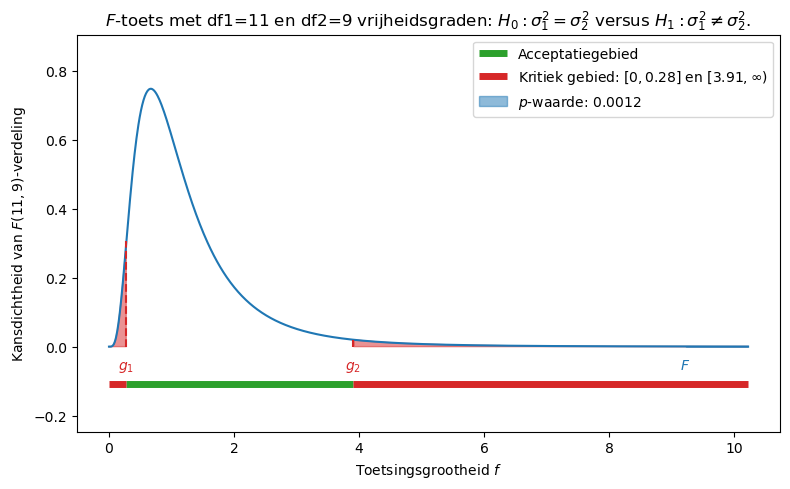

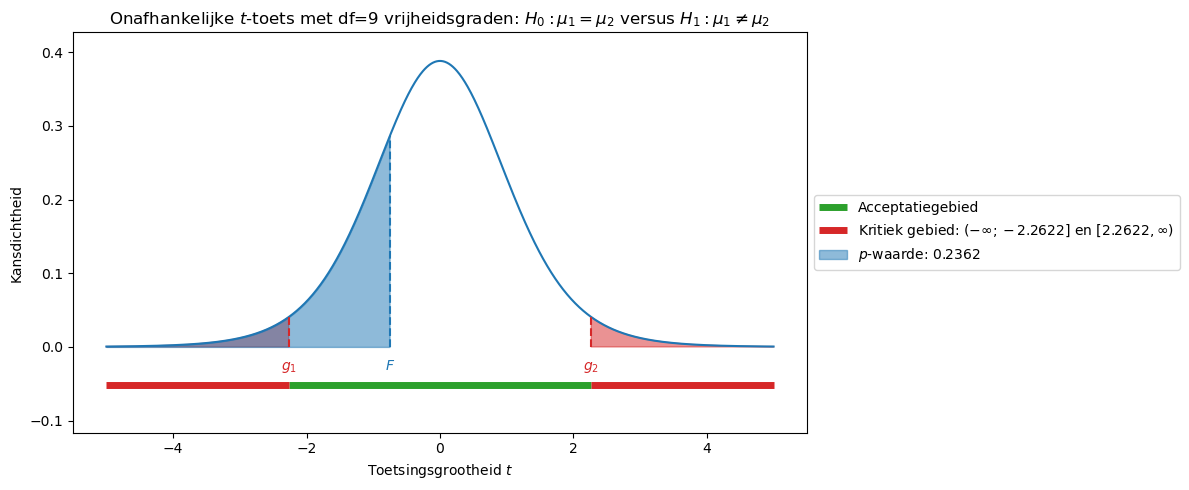

In [13]:
# Voor gegevens
data1 = [72, 85, 104, 55, 90, 77, 68, 50, 36, 63]
data2 = [78, 72, 81, 74, 85, 71, 69, 84, 66, 76, 65, 79]
alpha = 0.05
toetstype = "tweezijdig"

f_statistic, dfd, dfn, critical_region, p_value, conclusion = F_toets(data1, data2, alpha)
print("$F$-toets")
print(f"Toetsingsgrootheid: {f_statistic}")
print(f"Kritiek gebied: {critical_region}")
print(f"$p$-waarde: {p_value}")
print(f"Conclusie: {conclusion}")
plot_F_toets(f_statistic, alpha, dfn, dfd, filename=FIGURE_PATH + "plot_F_toets.png")

t_statistic, df, critical_region, p_value, conclusion = onafhankelijke_t_toets(data1, data2, alpha, toetstype)
print("Onafhankelijke $t$-toets")
print(f"Toetsingsgrootheid: {t_statistic}")
print(f"Kritiek gebied: {critical_region}")
print(f"$p$-waarde: {p_value}")
print(f"Conclusie: {conclusion}")
plot_t_toets(t_statistic, alpha, df, toetstype, filename=FIGURE_PATH + "plot_t_toets.png")

# Correlatie en regressie

In [14]:
def generate_latex_table(X, Y, labels):
    # Start building the LaTeX table
    xlabel, ylabel = labels.values()
    n = len(X)
    alignment_chars = "{c|" + "c" * n + "}"
    latex_code = f"""
        \\begin{{center}}
            \\begin{{tabular}}{alignment_chars}
                \\toprule
                    \\textbf{{{xlabel}}} {" ".join([f"& ${x}$" for x in X])} \\\\
                    \\textbf{{{ylabel}}} {" ".join([f"& ${y}$" for y in Y])} \\\\
                \\bottomrule
            \\end{{tabular}}
        \\end{{center}}
    """
    
    return latex_code

def generate_latex_table_regression(X, Y):
    X = np.array(X)
    Y = np.array(Y)
       
    # Start building the LaTeX table
    latex_code = """
        \\begin{center}
            \\begin{tabular}{ccccc}
                \\toprule
                    $x$ & $y$ & $xy$ & $x^2$ & $y^2$ \\\\
                \\midrule
    """
    
    # Populate table rows
    for x, y, xy, x2, y2 in zip(X, Y, X * Y, X ** 2, Y ** 2):
        x, y, xy, x2, y2 = map(lambda x: format_float(np.mean(x)), (x, y, xy, x2, y2))
        latex_code += f"\t\t${x}$ & ${y}$ & ${xy}$ & ${x2}$ & ${y2}$ \\\\\n"
    
    # Add final row with averages
    # Compute averages
    avg_X, avg_Y, avg_XY, avg_X_squared, avg_Y_squared = map(lambda x: format_float(np.mean(x)), [X, Y, X * Y, X ** 2, Y ** 2])

    latex_code += f"""
                \\midrule
                    $\\overline{{x}} = {avg_X}$ & $\\overline{{y}} = {avg_Y}$ & $\\overline{{xy}} = {avg_XY}$ & $\\overline{{x^2}} = {avg_X_squared}$ & $\\overline{{y^2}} = {avg_Y_squared}$ \\\\
                \\bottomrule
            \\end{{tabular}}
        \\end{{center}}
    """    
    return latex_code

def regression_coefficients_latex(X, Y):  
    X = np.array(X)
    Y = np.array(Y)
    
    avg_X = np.mean(X)
    avg_Y = np.mean(Y)
    avg_XY = np.mean(X * Y)
    avg_X_squared = np.mean(X ** 2)
    
    # Beta_1 (slope)
    numerator = avg_XY - avg_X * avg_Y
    denominator = avg_X_squared - avg_X**2
    beta_1 = numerator / denominator
    
    # Beta_0 (intercept)
    beta_0 = avg_Y - beta_1 * avg_X
    
    # LaTeX output
    latex_code = f"""
        \\begin{{align*}}
            b &= \\frac{{\\overline{{xy}} - \\overline{{x}} \\cdot \\overline{{y}}}}{{\\overline{{x^2}} - (\\overline{{x}})^2}} \\\\
              &= \\frac{{{avg_XY:.4f} - {avg_X:.4f} \\cdot {avg_Y:.4f}}}{{{avg_X_squared:.4f} - ({avg_X:.4f})^2}} \\\\
              &= \\frac{{{numerator:.4f}}}{{{denominator:.4f}}} \\approx {beta_1:.4f} \\\\
            a &= \\overline{{y}} - b \\cdot \\overline{{x}} \\\\
              &= {avg_Y:.4f} - {beta_1:.4f} \\cdot {avg_X:.4f} \\\\
              &\\approx {beta_0:.4f}.
        \\end{{align*}}
        
        De formule van de regressielijn behorende bij deze steekproef is dus gelijk aan $Y = {beta_0:.4f}{beta_1:+.4f}X$.
    """
    return latex_code, beta_0, beta_1


def pearson_correlation_latex(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    
    # Compute necessary statistical values
    avg_X, avg_Y, avg_XY, avg_X_squared, avg_Y_squared = np.mean(X), np.mean(Y), np.mean(X*Y), np.mean(X ** 2), np.mean(Y ** 2)

    
    # Compute Pearson correlation coefficient
    numerator = avg_XY - (avg_X * avg_Y)
    denominator = np.sqrt((avg_X**2 - avg_X_squared) * (avg_Y**2 - avg_Y_squared))
    r = numerator / denominator
    
    # Generate LaTeX output
    latex_code = f"""
        \\begin{{align*}}
            r(x,y)  &= \\frac{{ \\overline{{x \\cdot y}} - \\overline{{x}} \\cdot \\overline{{y}} }}{{ \\sqrt{{ (\\overline{{x}}^2 - \\overline{{x^2}}) \\cdot (\\overline{{y}}^2 - \\overline{{y^2}}) }} }}\\\\
                    &= \\frac{{ {avg_XY:.3f} - {avg_X:.3f} \\cdot {avg_Y:.3f} }}{{ \\sqrt{{ ({avg_X:.3f}^2 - {avg_X_squared:.3f}) \\cdot ({avg_Y:.3f}^{2} - {avg_Y_squared:.3f}) }} }} \\\\
                    &= \\frac{{{numerator:.3f}}}{{{denominator:.3f}}} \\\\
                    &\\approx {r:.4f}.
        \\end{{align*}}
    """
    
    return latex_code

def spearman_correlation_latex(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    
    if len(X) != len(Y):
        raise ValueError("Beide lijsten moeten dezelfde lengte hebben.")
    
    # Rangschik de gegevens
    ranks_X, ranks_Y = rankdata(X), rankdata(Y)
    print(ranks_X, ranks_Y)
    
    # Bereken de verschillen in rang
    d = ranks_X - ranks_Y
    d_squared = d ** 2
    sum_d_squared = sum(d_squared)
    n = len(X)
    alignment_chars = "c" + "c" * n
    
    # Spearman's rho
    numerator = 6 * np.sum(d_squared)
    denominator = n * (n**2 - 1)
    rho = 1 - (numerator / denominator)
    
    # Genereer LaTeX-uitvoer
    latex_code = f"""
        De eerste stap bij het berekenen van Spearman's correlatieco\\"effici\\"ent is het bepalen van de rankings van de uitkomsten voor $X$ en $Y$:
        \\begin{{center}}
            \\begin{{tabular}}{{{alignment_chars}}}
                \\toprule
                    {{\\bfseries Rangnummers $X$-waarden}} {" ".join([f"& ${i}$" for i in ranks_X])} \\\\
                    {{\\bfseries Rangnummers $Y$-waarden}} {" ".join([f"& ${i}$" for i in ranks_Y])} \\\\
                \\midrule
                    {{\\bfseries Verschillen $d_i$}} {" ".join([f"& ${diff}$" for diff in d])} \\\\
                    {{\\bfseries Kwadratische verschillen $d_i^2$}} {" ".join([f"& ${diff2}$" for diff2 in d_squared])} \\\\
                \\bottomrule
            \\end{{tabular}}
        \\end{{center}}

        De som van de kwadratische rangnummerverschillen is gelijk aan $\\sum_i d_i^2 = {sum_d_squared}$.
        Aangezien de steekproefgrootte gelijk is aan $n = {n}$, is de rangcorrelatieco\\"effici\\"ent van Spearman gelijk aan
        \\begin{{align*}}
            r_s &= 1 - \\frac{{ 6 \\cdot \\sum_i d_i^2 }}{{ n^3 - n }}  \\\\
                &= 1 - \\frac{{ 6 \\cdot {sum_d_squared} }}{{ {n}^3 - {n} }}  \\\\
                &\\approx {rho:.4f}.
        \\end{{align*}}
    """
    
    return latex_code

## Betrouwbaarheidsinterval en voorspellingsinterval gegeven een $x$-waarde

In [15]:
def regression_confidence_interval(X, Y, beta_0, beta_1, x0, confidence=0.95):
    X = np.array(X)
    Y = np.array(Y)
    n = len(X)
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    mean_X2 = np.mean(X ** 2)
    mean_XY = np.mean(X * Y)
    mean_Y2 = np.mean(Y ** 2)
    confidence_percentage = int(100 * confidence)
    
    # 1. Compute the error terms and estimate the standard deviation of the error terms
    error_terms = Y - (beta_0 + beta_1 * X)
    sample_std_error = np.sqrt( np.sum( error_terms ** 2) / (n - 2) ) 

    # 2. Use the estimate to estimate the standard deviation of the mean Y given x
    sample_std_mean = sample_std_error * np.sqrt( 1 / n * (1 + ((x0 - mean_X) ** 2 / (mean_X2 - mean_X ** 2))) )

    y_pred = beta_0 + beta_1 * x0   
    t_crit = t.ppf((1 + confidence) / 2, df=n - 2)
    margin_error = t_crit * sample_std_mean

    # Generate LaTeX output
    latex_code = f"""
        De eerste stap is om de puntschatting voor $Y$ te bepalen aan de hand van de regressielijn $Y = {beta_0:.4f}{beta_1:+.4f}X$ door $X = {x0}$ in te vullen.
        Dit geeft ons een puntschatting van $y_0 = {beta_0:.4f} {beta_1:+.4f} \\cdot {x0} \\approx {y_pred:.4f}$.
        Daarnaast kunnen we de standaardafwijking $\\sigma$ van de storingsterm $\\varepsilon$ schatten:
        \\begin{{align*}}
            s_{{\\varepsilon}} &= \\sqrt{{ \\frac{{n}}{{n-2}} \\cdot \\left( \\overline{{y^2}} - a \\cdot \\overline{{y}} - b \\cdot \\overline{{xy}} \\right) }} \\\\ 
                               &= \\sqrt{{ \\frac{{{n}}}{{{n-2}}} \\cdot \\left( {mean_Y2:.4f} - {beta_0:.4f} \\cdot {mean_Y:.4f} - {beta_1:.4f} \\cdot {mean_XY:.4f} \\right) }} \\\\ 
                               &\\approx {sample_std_error:.4f}.
        \\end{{align*}}

        Vervolgens kunnen we een puntschatting berekenen van de standaardafwijking van de verwachtingswaarde van $Y$ voor gegeven $X = x_0$:
        \\begin{{align*}}
        s_{{\\mu}}  &= s_{{\\varepsilon}} \\cdot \\sqrt{{ \\frac{{1}}{{n}} \\cdot \\left( 1 + \\frac{{(x_0 - \\overline{{x}})^2}}{{\\overline{{x^2}} - \\overline{{x}}^2}} \\right) }} \\\\
                    &= {sample_std_error} \\cdot \\sqrt{{ \\frac{{1}}{{{n}}} \\cdot \\left( 1 + \\frac{{({x0:.4f} - {mean_X:.4f})^2}}{{{mean_X2:.4f} - {mean_X:.4f}^2}} \\right) }} \\\\
                    &\\approx {sample_std_mean:.4f}.   
        \\end{{align*}}

        Omdat we de standaardafwijkingen geschat hebben en de storingstermen normaal verdeeld zijn, moeten we werken met de $t$-verdeling met $df = n - 2 = {n-2}$ vrijheidsgraden.
        De $t$-waarde die hoort bij een betrouwbaarheidsniveau $\\alpha = {1-confidence}$ is gelijk aan
        \\[
            t = \\invt(\\text{{opp}} = 1 - \\alpha / 2; \\text{{df}} = n - 2) = \\invt(\\text{{opp}} = {1-alpha/2}; \\text{{df}} = {n-2}) \\approx {t_crit:.4f}.
        \\]
        Het ${int(100 * confidence)}\\%$-betrouwbaarheidsinterval voor de gemiddelde $Y$ voor gegeven $X = x_0$ kan dus worden beschreven door
        \\begin{{align*}}
            &[y_0 - t \\cdot s_{{\\mu}}; y_0 - t \\cdot s_{{\\mu}}] \\\\
            &= [{y_pred:.4f} - {t_crit:.4f} \\cdot {sample_std_mean:.4f}; {y_pred:.4f} + {t_crit:.4f} \\cdot {sample_std_mean:.4f}] \\\\
            &\\approx [{y_pred - margin_error:.4f}; {y_pred + margin_error:.4f}].
        \\end{{align*}}
        
        Met \\SI{{{confidence_percentage}}}{{\\percent}} betrouwbaarheid ligt het gemiddelde van $Y$ voor gegeven $X = {x0}$ tussen ${y_pred - margin_error:.4f}$ en ${y_pred + margin_error:.4f}$.       
    """
    ci = (y_pred - margin_error, y_pred + margin_error)
    return latex_code, y_pred, ci

def regression_prediction_interval(X, Y, beta_0, beta_1, x0, confidence=0.95):
    X = np.array(X)
    Y = np.array(Y)
    n = len(X)
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)
    mean_X2 = np.mean(X ** 2)
    mean_XY = np.mean(X * Y)
    mean_Y2 = np.mean(Y ** 2)
    confidence_percentage = int(100 * confidence)

    error_terms = Y - (beta_0 + beta_1 * X)
    sample_std_error = np.sqrt( np.sum(error_terms ** 2) / (n - 2) )

    sample_std_pred = sample_std_error * np.sqrt( 1 + 1 / n * (1 + ((x0 - mean_X) ** 2 / (mean_X2 - mean_X ** 2))) )

    y_pred = beta_0 + beta_1 * x0
    t_crit = t.ppf((1 + confidence) / 2, df=n - 2)
    margin_error = t_crit * sample_std_pred
    pi_left, pi_right = (y_pred - margin_error, y_pred + margin_error)
    latex_code = f"""
        De eerste stap is om de puntschatting voor $Y$ te bepalen aan de hand van de regressielijn $Y = {beta_0:.4f}{beta_1:+.4f} \\cdot X$ door $X = {x0}$ in te vullen.
        Dit geeft ons een puntschatting van $y_0 = {beta_0:.4f} {beta_1:+.4f} \\cdot {x0} \\approx {y_pred:.4f}$.
        Daarnaast kunnen we de standaardafwijking $\\sigma$ van de storingsterm $\\varepsilon$ schatten:
        \\begin{{align*}}
            s_{{\\varepsilon}} &= \\sqrt{{ \\frac{{n}}{{n-2}} \\cdot \\left( \\overline{{y^2}} - a \\cdot \\overline{{y}} - b \\cdot \\overline{{xy}} \\right) }} \\\\ 
                               &= \\sqrt{{ \\frac{{{n}}}{{{n-2}}} \\cdot \\left( {mean_Y2:.4f} - {beta_0:.4f} \\cdot {mean_Y:.4f} - {beta_1:.4f} \\cdot {mean_XY:.4f} \\right) }} \\\\ 
                               &\\approx {sample_std_error:.4f}. 
        \\end{{align*}}

        Vervolgens kunnen we een puntschatting berekenen van de standaardafwijking van $Y$ voor gegeven $X = x_0$:
        \\begin{{align*}}
            s_{{f}} &= s_{{\\varepsilon}} \\cdot \\sqrt{{ 1 + \\frac{{1}}{{n}} \\cdot \\left( 1 + \\frac{{(x_0 - \\overline{{x}})^2}}{{\\overline{{x^2}} - \\overline{{x}}^2}} \\right) }} \\\\
                    &= {sample_std_error:.4f} \\cdot \\sqrt{{ 1 + \\frac{{1}}{{{n}}} \\cdot \\left( 1 + \\frac{{({x0} - {mean_X:.4f})^2}}{{{mean_X2:.4f} - {mean_X:.4f}^2}} \\right) }} \\\\
                    &\\approx {sample_std_pred:.4f}.         
        \\end{{align*}}

        Omdat we de standaardafwijkingen geschat hebben en de storingstermen normaal verdeeld zijn, moeten we werken met de $t$-verdeling met $df = n - 2 = {n-2}$ vrijheidsgraden.
        De $t$-waarde die hoort bij een betrouwbaarheidsniveau $\\alpha = {1-confidence}$ is gelijk aan
        \\[
            t = \\invt(\\text{{opp}} = 1 - \\alpha / 2; \\text{{df}} = n - 2) = \\invt(\\text{{opp}} = {1-alpha/2}; \\text{{df}} = {n-2}) \\approx {t_crit:.4f}.
        \\]
        Het \\SI{{{confidence_percentage}}}{{\\percent}}-betrouwbaarheidsinterval voor de gemiddelde $Y$ voor gegeven $X = x_0$ kan dus worden beschreven door
        \\begin{{align*}}
            &[y_0 - t \\cdot s_{{f}}; y_0 - t \\cdot s_{{f}}] \\\\ 
            &= [{y_pred:.4f} - {t_crit:.4f} \\cdot {sample_std_pred:.4f}; {y_pred:.4f} + {t_crit:.4f} \\cdot {sample_std_pred:.4f}] \\\\ 
            &\\approx [{y_pred - margin_error:.4f}; {y_pred + margin_error:.4f}]. 
        \\end{{align*}}
        
        Met \\SI{{{confidence_percentage}}}{{\\percent}} betrouwbaarheid ligt een toekomstige uitkomst van $Y$ voor gegeven $X = {x0}$ tussen ${pi_left:.4f}$ en ${pi_right:.4f}$.
    """

    return latex_code, y_pred, (pi_left, pi_right)


In [16]:
def add_midpoint_lines_and_quadrants(mean_X, mean_Y):
    left, right = plt.xlim()
    bottom, top = plt.ylim()

    plt.axvline(mean_X, linestyle="--", color=secondary_plot_color)
    plt.axhline(mean_Y, linestyle="--", color=secondary_plot_color)

    p, q = 0.2, 0.8
    quadrant_labels = [
        (p * mean_X + (1 - p) * right, q * mean_Y + (1 - q) * top, "> 0", "> 0"),
        (p * mean_X + (1 - p) * left, q * mean_Y + (1 - q) * top, "< 0", "> 0"),
        (p * mean_X + (1 - p) * left, q * mean_Y + (1 - q) * bottom, "< 0", "< 0"),
        (p * mean_X + (1 - p) * right, q * mean_Y + (1 - q) * bottom, "> 0", "< 0"),
    ]
    for x, y, dx, dy in quadrant_labels:
        plt.text(x, y, f"$x_i - \\overline{{x}} {dx}$\n$y_i - \\overline{{y}} {dy}$", ha="center", va="center")

def fit_regression_and_plot_line(X, Y):
    model = LinearRegression()
    model.fit(X, Y)
    x_vals = np.linspace(np.min(X), np.max(X), 200).reshape(-1, 1)
    y_hat = model.predict(x_vals)

    m, b = model.coef_[0], model.intercept_
    label = f"Regressielijn: $Y = {b:.4f}{m:+.4f}X$"
    plt.plot(x_vals, y_hat, color=critical_color, label=label)

    return model, x_vals.ravel(), y_hat

def plot_residuals(X, Y, model):
    for i, (xi, yi) in enumerate(zip(X[:, 0], Y)):
        y_pred = model.predict([[xi]])[0]
        label = "Afstanden: $e_i = y_i - (a + b \\cdot x_i)$" if i == 0 else None
        plt.plot([xi, xi], [yi, y_pred], linestyle="--", color=primary_plot_color, alpha=0.6, label=label)
    
def plot_y0(x_0, model):
    left, right = plt.xlim()
    bottom, top = plt.ylim()
    y_0 = model.predict([[x_0]])[0]

    plt.plot([x_0, x_0], [bottom, y_0], linestyle="--", color=primary_plot_color)
    plt.plot([left, x_0], [y_0, y_0], linestyle="--", color=primary_plot_color,
             label=f"Puntschatting voor $Y \\mid X = {x_0}$: ${y_0:.4f}$")

def plot_intervals(X, Y, x_vals, y_hat, model, x_0, plot_prediction_interval, plot_confidence_interval):
    n = len(X)
    x_mean = np.mean(X)
    Sxx = np.sum((X - x_mean) ** 2)
    residuals = Y - model.predict(X)
    s_squared = np.sum(residuals ** 2) / (n - 2)
    s = np.sqrt(s_squared)
    t_val = t.ppf(0.975, df=n - 2)

    se_mean = s * np.sqrt(1/n + (x_vals - x_mean)**2 / Sxx)
    se_pred = s * np.sqrt(1 + 1/n + (x_vals - x_mean)**2 / Sxx)

    ci_upper, ci_lower = y_hat + t_val * se_mean, y_hat - t_val * se_mean
    pi_upper, pi_lower = y_hat + t_val * se_pred, y_hat - t_val * se_pred

    if plot_prediction_interval:
        plt.fill_between(x_vals, pi_lower, pi_upper, color=critical_color, alpha=0.2,
                         label='Voorspellingsinterval (voor $Y \\mid X$)')
        if x_0:
            y_0 = model.predict([[x_0]])[0]
            se_pred_0 = s * np.sqrt(1 + 1/n + (x_0 - x_mean)**2 / Sxx)
            lower, upper = y_0 - t_val * se_pred_0, y_0 + t_val * se_pred_0
            plt.plot([x_0, x_0], [lower, upper], color=critical_color, linestyle="--", alpha=0.3,
                     label=f'Voorspellingsinterval (voor $Y \\mid X={x_0}$): [{lower:.4f}; {upper:.4f}]')

    if plot_confidence_interval:
        plt.fill_between(x_vals, ci_lower, ci_upper, color=acceptable_color, alpha=0.3,
                         label='Betrouwbaarheidsinterval (voor $E[Y \\mid X]$)')
        if x_0:
            y_0 = model.predict([[x_0]])[0]
            se_mean_0 = s * np.sqrt(1/n + (x_0 - x_mean)**2 / Sxx)
            lower, upper = y_0 - t_val * se_mean_0, y_0 + t_val * se_mean_0
            plt.plot([x_0, x_0], [lower, upper], color=acceptable_color, linestyle="--", alpha=0.3,
                     label=f'Betrouwbaarheidsinterval (voor $E[Y \\mid X={x_0}$): [{lower:.4f}; {upper:.4f}]')
            

def plot_linear_regression(
        X, Y, labels, filename, x_0=None,
        plot_midpoint_lines=False, plot_least_squares=False, plot_regression_line=False, 
        plot_point_estimate=False,
        plot_prediction_interval=False, plot_confidence_interval=False
):
    # Convert lists to numpy arrays
    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y)

    mean_X, mean_Y = np.mean(X), np.mean(Y)

    # Create scatter plot
    plt.scatter(X, Y, color=primary_plot_color)
    plt.title(f'Spreidingsdiagram: {labels["X"]} vs. {labels["Y"]}')
    
    # Label axes and add title
    plt.xlabel(labels["X"])
    plt.ylabel(labels["Y"])

    if plot_midpoint_lines:
        add_midpoint_lines_and_quadrants(mean_X, mean_Y)
              
    if plot_regression_line:
        model, x_vals, y_hat = fit_regression_and_plot_line(X, Y)
    
        if plot_least_squares:
            plot_residuals(X, Y, model)

        if x_0 and plot_point_estimate:
            plot_y0(x_0, model)
    
        if plot_prediction_interval or plot_confidence_interval:
            plot_intervals(X, Y, x_vals, y_hat, model, x_0, plot_prediction_interval, plot_confidence_interval)

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    
    # Save plot
    plt.savefig(filename, bbox_inches='tight')




        \begin{center}
            \begin{tabular}{c|cccccccccc}
                \toprule
                    \textbf{cilinderinhoud (liters)} & $1.2$ & $0.8$ & $0.8$ & $2.0$ & $1.4$ & $1.0$ & $1.6$ & $1.8$ & $1.3$ & $1.1$ \\
                    \textbf{maximum snelheid (km/uur)} & $140$ & $110$ & $100$ & $180$ & $150$ & $100$ & $160$ & $190$ & $140$ & $130$ \\
                \bottomrule
            \end{tabular}
        \end{center}
    

        \begin{center}
            \begin{tabular}{ccccc}
                \toprule
                    $x$ & $y$ & $xy$ & $x^2$ & $y^2$ \\
                \midrule
    		$1.2$ & $140$ & $168$ & $1.44$ & $19600$ \\
		$0.8$ & $110$ & $88$ & $0.64$ & $12100$ \\
		$0.8$ & $100$ & $80$ & $0.64$ & $10000$ \\
		$2$ & $180$ & $360$ & $4$ & $32400$ \\
		$1.4$ & $150$ & $210$ & $1.96$ & $22500$ \\
		$1$ & $100$ & $100$ & $1$ & $10000$ \\
		$1.6$ & $160$ & $256$ & $2.56$ & $25600$ \\
		$1.8$ & $190$ & $342$ & $3.24$ & $36100$ \\
		$1.3$ & $140$ & $182$ & $1.6

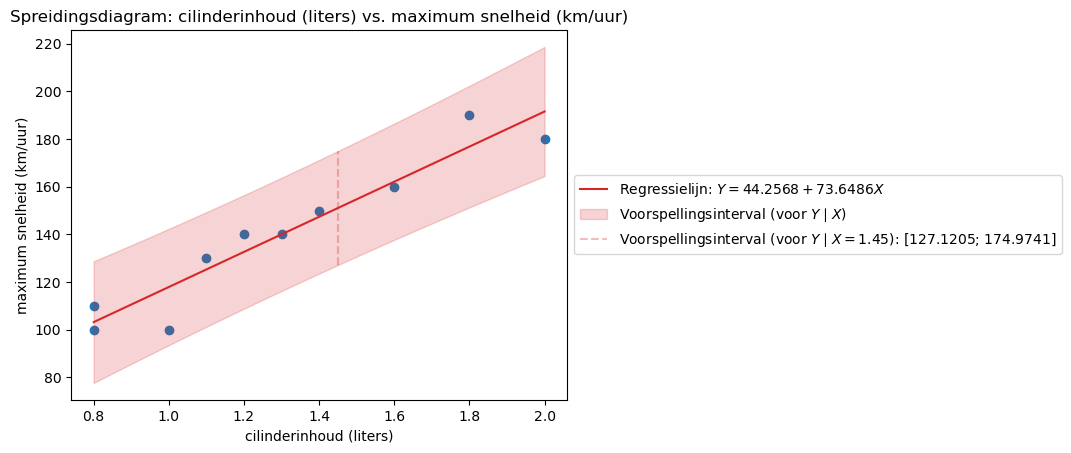

In [17]:
np.random.seed(42)  # Zet de seed
X = [1.2, 0.8, 0.8, 2.0, 1.4, 1.0, 1.6, 1.8, 1.3, 1.1]
            # + np.random.normal(loc=0, scale=40, size=len(Y))# oefeningstijd (min)
Y = [140, 110, 100, 180, 150, 100, 160, 190, 140, 130]  # schietscore (%)

X_pred = 1.45
labels = {
    "X": "cilinderinhoud (liters)",
    "Y": "maximum snelheid (km/uur)"
}

# Generate LaTeX table for the question itself (horizontal)
latex_table = generate_latex_table(X, Y, labels)
print(latex_table)

# Plot X and Y in a scatter plot
plot_linear_regression(X, Y, labels, x_0 = X_pred, \
                           plot_least_squares=False, plot_regression_line=True, \
                           plot_point_estimate=False, plot_prediction_interval=True,\
                           filename=FIGURE_PATH + "opg13.15e.png")

# Generate LaTeX table for computing the regression line and the correlation coefficient
regression_table = generate_latex_table_regression(X, Y)
print(regression_table)

regression_coefficients, a, b = regression_coefficients_latex(X, Y)
print(regression_coefficients)

Y_pred = a + b * X_pred
print(f"Voorspelde waarde voor $Y$ bij $X = {X_pred}$ is gelijk aan {Y_pred}")

pearson = pearson_correlation_latex(X, Y)
print(pearson)

# Confidence interval for the mean given x0
x0 = 1.45
alpha = 0.05

confidence_interval, y_pred, ci = regression_confidence_interval(X, Y, a, b, x0, confidence=1-alpha)
print(confidence_interval)

prediction_interval, y_pred, pi = regression_prediction_interval(X, Y, a, b, x0, confidence=1-alpha)
print(prediction_interval)